In [33]:
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

DIR = "C:\\Users\\97252\\Documents\\year_4\\project\\Xanthomonas Oryzae\\ncbi-genomes-fasta-2022-02-02\\unzipped"

In [35]:
def find_lens(dir):
    lens = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        seq_len = 0
        for seq_record in SeqIO.parse(f, "fasta"):
            seq_len += len(seq_record)
        lens.append(seq_len)
    return lens

In [36]:
lens = find_lens(DIR)

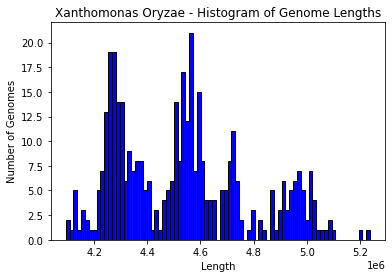

In [37]:
plt.hist(lens, color = 'blue', edgecolor = 'black',
         bins = int(len(lens)/5))

plt.title('Xanthomonas Oryzae - Histogram of Genome Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Genomes')
plt.savefig("Xanthomonas Oryzae - Histogram of Genome Lengths.png")

C:\Users\97252\anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using scott for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


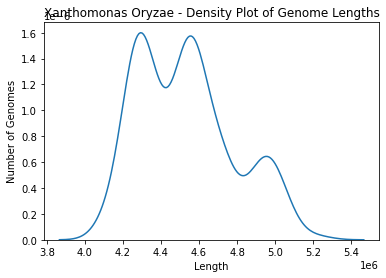

In [38]:
sns.kdeplot(lens, bw="scott")
plt.title('Xanthomonas Oryzae - Density Plot of Genome Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Genomes')
plt.savefig("Xanthomonas Oryzae - Density Plot of Genome Lengths.png")

In [39]:
len(lens)

396

In [19]:
from Bio import SeqIO
import os
import pandas as pd
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import re

ASSEMBLY_LEVEL_DIC = {"complete genome": 1, "chromosome": 2, "scaffold": 3, "contig": 4} #the smaller the number the better
#TODO: search to see that this is how it is spelled

def get_org_dict(stats_dir):
    org_dict = {}
    for stats_filename in os.listdir(stats_dir):
        if stats_filename.endswith("stats.txt"):
            cur_dict = {}
            with open(os.path.join(stats_dir, stats_filename)) as stats_file:
                for line in stats_file:
                    if line.startswith("# Organism name:"):
                        cur_dict["organism_name"] = line.split(":")[-1].lstrip().strip("\n")
                    elif line.startswith("# Infraspecific name:  strain="):
                        cur_dict["strain"] = line.split("strain=")[-1].strip("\n")
                    elif line.startswith("# Date:"):
                        cur_dict["date"] = line.split()[-1].strip("\n")
                    elif line.startswith("# Assembly level:"):
                        cur_dict["assembly_level"] =  line.split(":")[-1].lstrip().strip("\n")
                        cur_dict["assembly_level_int"] = ASSEMBLY_LEVEL_DIC[cur_dict["assembly_level"].lower()]
                    elif line.startswith("# RefSeq assembly accession:"):
                        cur_dict["refseq_accesion_id"] = line.split()[-1].strip("\n")
                        break
            if not cur_dict.get("organism_name") or not cur_dict.get("date") or not cur_dict.get("refseq_accesion_id") or not cur_dict.get("assembly_level"):
                print("ERROR: file= %s has missing info" % stats_filename)
                break

            org_full_name = get_full_name(cur_dict)

            if not org_dict.get(org_full_name):
                org_dict[org_full_name] = []
            org_dict[org_full_name].append({"date": cur_dict["date"], "refseq_accesion_id": cur_dict["refseq_accesion_id"], "assembly_level": cur_dict["assembly_level"], "assembly_level_int":  cur_dict["assembly_level_int"]})

    return org_dict

def get_full_name(cur_dict):
    org_name = re.sub(r"\([^()]*\)", "", cur_dict["organism_name"]).strip() #remove whatever is in parenthesis
    if (not cur_dict.get("strain")) or (cur_dict["strain"] in org_name):
        return org_name
    else:
        return org_name + " " + cur_dict["strain"]

def get_latest_data_df(organism_dic):
    df_dict = {"organism name":[], "number of assemblies":[], "last assembly level": [], "if best assembly level":[], "last GenBank acession ID":[], "last assembly date": []}
    for org, items in organism_dic.items():
        first_item = items[0] #default value
        last_date = datetime.strptime(first_item["date"], "%Y-%m-%d")
        last_accession_id = first_item["GenBank_accesion_id"]
        last_assembly_level = first_item["assembly_level"]
        last_assembly_level_int = first_item["assembly_level_int"]
        min_assembly_level_int = first_item["assembly_level_int"]  
 
        if len(items) > 1: #more than one assembly of the genome
            for item in items:
                date = datetime.strptime(item["date"], "%Y-%m-%d")
                if date > last_date:
                    last_date = date
                    last_accession_id = item["GenBank_accesion_id"]
                    if item["assembly_level_int"] <= min_assembly_level_int:
                        min_assembly_level_int = item["assembly_level_int"]
                    else: 
                        print(item["assembly_level"], last_assembly_level)
                    last_assembly_level_int = item["assembly_level_int"]
                    last_assembly_level = item["assembly_level"]
        
        df_dict["organism name"].append(org)
        df_dict["last assembly date"].append(last_date)
        df_dict["number of assemblies"].append(len(items))
        df_dict["last GenBank acession ID"].append(last_accession_id)
        df_dict["last assembly level"].append(last_assembly_level)
        df_dict["if best assembly level"].append(last_assembly_level_int == min_assembly_level_int)
    return pd.DataFrame(df_dict)

In [20]:
stats_dir = "C:\\Users\\97252\\Documents\\year_4\\bio_project_data\\Xanthomonas Oryzae\\ncbi-genomes-stats-2022-02-02\\stats"

organism_dic = get_org_dict(stats_dir)
df = get_latest_data_df(organism_dic)
df.sort_values(by=["number of assemblies"], inplace=True, ascending=False)
display(df)

Contig Complete Genome


,organism name,number of assemblies,last assembly level,if best assembly level,last GenBank acession ID,last assembly date
146,Xanthomonas oryzae pv. oryzae YN11,3,Scaffold,True,GCA_003294225.1,2018-07-09
186,Xanthomonas oryzae pv. oryzae JL15,2,Scaffold,True,GCA_003295125.1,2018-07-09
229,Xanthomonas oryzae pv. oryzae JL3,2,Scaffold,True,GCA_003296305.1,2018-07-09
374,Xanthomonas oryzae pv. oryzicola GX01,2,Complete Genome,True,GCA_020084945.1,2021-09-21
14,Xanthomonas oryzae pv. oryzicola BXOR1,2,Contig,False,GCA_001929305.1,2017-01-03
...,...,...,...,...,...,...
127,Xanthomonas oryzae pv. oryzae IXO1088,1,Complete Genome,True,GCA_001929235.2,2020-03-06
126,Xanthomonas oryzae pv. oryzae IXO884,1,Contig,True,GCA_001929225.1,2017-01-03
125,Xanthomonas oryzae pv. oryzae IXO812,1,Contig,True,GCA_001929185.1,2017-01-03
124,Xanthomonas oryzae pv. oryzae IXO842,1,Contig,True,GCA_001929165.1,2017-01-03


In [21]:
stats_dir = "C:\\Users\\97252\\Documents\\year_4\\bio_project_data\\Xanthomonas\\ncbi-genomes-stats-refseq-2022-02-07"

organism_dic = get_org_dict(stats_dir)
df = get_latest_data_df(organism_dic)
df.sort_values(by=["number of assemblies"], inplace=True, ascending=False)
display(df)

Contig Complete Genome
Contig Scaffold
Contig Scaffold
Contig Scaffold
Contig Scaffold
Contig Scaffold


,organism name,number of assemblies,last assembly level,if best assembly level,last GenBank acession ID,last assembly date
1672,Xanthomonas translucens pv. graminis,5,Contig,True,GCA_900092365.1,2016-12-16
1753,Xanthomonas euroxanthea,5,Complete Genome,True,GCA_905367725.1,2021-03-24
1758,Xanthomonas arboricola pv. juglandis,3,Complete Genome,True,GCA_905367715.1,2021-03-24
637,Xanthomonas oryzae pv. oryzae YN11,3,Scaffold,True,GCA_003294225.1,2018-07-09
583,Xanthomonas vasicola pv. vasculorum SAM119,2,Complete Genome,True,GCA_003015715.1,2018-03-26
...,...,...,...,...,...,...
586,Xanthomonas citri pv. vignicola CFBP7112,1,Complete Genome,True,GCA_002218265.1,2017-07-13
585,Xanthomonas citri pv. vignicola CFBP7111,1,Complete Genome,True,GCA_002218245.1,2017-07-13
584,Xanthomonas vasicola pv. vasculorum NE744,1,Contig,True,GCA_002191965.1,2017-06-13
582,Xanthomonas oryzae pv. oryzicola BAI21,1,Scaffold,True,GCA_002189465.1,2017-06-09


In [10]:
df[df["if best assembly level"] == 0]

,organism name,number of assemblies,last assembly level,if best assembly level,last GenBank acession ID,last assembly date
706,Xanthomonas vasicola pv. zeae X15,2,Contig,False,GCA_012844555.1,2020-04-26
707,Xanthomonas vasicola pv. zeae X23,2,Contig,False,GCA_012844625.1,2020-04-26
708,Xanthomonas vasicola pv. zeae X02,2,Contig,False,GCA_012844565.1,2020-04-26
709,Xanthomonas vasicola pv. zeae X22,2,Contig,False,GCA_012844585.1,2020-04-26
711,Xanthomonas vasicola pv. zeae X01,2,Contig,False,GCA_012844535.1,2020-04-26
337,Xanthomonas oryzae pv. oryzicola BXOR1,2,Contig,False,GCA_001929305.1,2017-01-03


In [23]:
df[df["last GenBank acession ID"]=="GCA_000010025.1"]

,organism name,number of assemblies,last assembly level,if best assembly level,last GenBank acession ID,last assembly date
3,Xanthomonas oryzae pv. oryzae MAFF 311018,1,Complete Genome,True,GCA_000010025.1,2006-01-04


In [32]:
df.to_csv("xantho_table_results.csv")

In [13]:
df_ = df[df["number of assemblies"] > 1]

In [15]:
df_.shape

(35, 6)

questions - does it make sense that so little have duplicates?
           - is it enough to use strain name? If we compare different species...
1. Check that the dates are correct (correctly gives the latest one - check with example)
2. Add Git repository to save my work
3. Add column for pv - empty if there isnt
4. Check difference between having pv in name or not